In [4]:
import heapq
from matplotlib import pyplot as plt
from pprint import pprint
from collections import deque, defaultdict
from typing import List, Optional, Tuple, Set, DefaultDict
from mapfmclient import MapfBenchmarker, Problem, Solution, MarkedLocation


class Location:
    def __init__(self, x: int, y: int):
        self.x: int = x
        self.y: int = y

    def __eq__(self, other) -> bool:
        return self.x == other.x and self.y == other.y

    def __hash__(self):
        return hash((self.x, self.y))

    def __str__(self):
        return '('+str(self.x)+','+str(self.y)+')'

    @classmethod
    def from_dict(cls, dct) -> "Location":
        return cls(dct["x"], dct["y"])


class Node:
    def __init__(self, parent, loc: Location, cost: int, heuristic: int):
        self.parent: Optional[Node] = parent
        self.loc: Location = loc
        self.cost: int = cost
        self.heuristic: int = heuristic

    def __hash__(self):
        return hash(self.loc)

    def is_root(self):
        return self.parent is None

    def is_goal(self, goal: Location) -> bool:
        return self.loc == goal

    def get_directions(self):
        if self.is_root():
            return [self.loc]
        else:
            par_dirs = self.parent.get_directions()
            par_dirs.append(self.loc)
            return par_dirs

    def __eq__(self, other) -> bool:
        return self.cost + self.heuristic == other.cost + other.heuristic

    def __ne__(self, other) -> bool:
        return self.cost + self.heuristic != other.cost + other.heuristic

    def __ge__(self, other) -> bool:
        return self.cost + self.heuristic >= other.cost + other.heuristic

    def __lt__(self, other) -> bool:
        return self.cost + self.heuristic < other.cost + other.heuristic

    def __gt__(self, other) -> bool:
        return self.cost + self.heuristic > other.cost + other.heuristic

    def __le__(self, other) -> bool:
        return self.cost + self.heuristic <= other.cost + other.heuristic


class Maze:
    def __init__(self, grid: List[List[int]], width: int, height: int):
        self.grid = grid
        self.width = width
        self.height = height

    def get_valid_children(self, loc: Location) -> List[Location]:
        x, y = loc.x, loc.y
        all_children: List[Tuple[int, int]] = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1), (x, y)]
        good_children: List[Tuple[int, int]] = []
        for c in all_children:
            if 0 <= c[0] < self.height and 0 <= c[1] < self.width:
                if not self.grid[c[1]][c[0]]:
                    good_children.append(c)
        return list(map(lambda x: Location(x[0], x[1]), good_children))


def heuristic(node: Location, goal: Location) -> int:
    return abs(goal.x - node.x) + abs(goal.y - node.y)


class MDD:
    def __init__(self, maze: Maze, agent: int, start: Location, goal: Location, depth: int):
        self.agent: int = agent
        self.start: Location = start
        self.goal: Location = goal
        self.depth: int = depth
        tree = construct_bfs_tree(maze,start,depth)
        self.mdd: Optional[DefaultDict[Tuple[Location, int], Set[Tuple[Location, int]]]] = mdd_from_tree(tree,goal,depth)
    
    # Constructs a graph of the MDD.
    def show(self):
        items = list(sorted(self.mdd.items(),key = lambda x : x[0][1]))
        g = Digraph()
        added = set()
        plt.tight_layout()
        for ((loc,d),v) in items:
            node_str = str(loc)+','+str(d)
            g.node(node_str)
            for (c_loc,c_depth) in v:
                child_str = str(c_loc)+','+str(c_depth)
                if not child_str in added:
                    added.add(child_str)
                g.edge(node_str, child_str)
        return g
"""
Constructs a top-down MDD structure in the form of a dictionary of parent-children mappings representing all the ways to
get to the goal-node. This is done by tracing paths back to the start through the bottom-up DAG that was constructed
when doing the breadth-first traversal. This is similar to tracing a single path back up as in path-finding (consider
the get_directions function in the A* Node class), but here there are typically many paths that can be taken, resulting 
in an MDD.
TLDR: turns a child-parents structure into a parent-children structure with some filtering along the way
"""
def mdd_from_tree(tree: DefaultDict[Tuple[Location, int], Set[Tuple[Location, int]]], goal: Location, depth: int) \
        -> Optional[DefaultDict[Tuple[Location, int], Set[Tuple[Location, int]]]]:
    goal_at_depth = (goal,depth)
    # If the goal node is not in the DAG, return the empty MDD represented by None
    if not tree[goal_at_depth]:
        return None
    visited = set()
    mdd = defaultdict(set)
    trace_list = deque()
    for parent in tree[goal_at_depth]:
        trace_list.append((parent,goal_at_depth))
        visited.add((parent,goal_at_depth))
    while trace_list:
        current, child = trace_list.popleft()
        mdd[current].add(child)
        for parent in tree[current]:
            if (parent,current) not in visited:
                trace_list.append((parent,current))
                visited.add((parent,current))
    return mdd


def construct_bfs_tree(maze: Maze, start: Location, depth: int) -> DefaultDict[
    Tuple[Location, int], Set[Tuple[Location, int]]]:
    fringe = deque()
    fringe.append((start, 0))
    # DAG represented by child-parents map. This formulation makes it easier to construct the path(s) from the parents
    # to the child later, similar to the get_directions function in the A* Node class
    prev_dict = defaultdict(set)
    visited = set()
    while fringe:
        current: Tuple[Location, int] = fringe.popleft()
        loc, d = current
        children: List[Tuple[Location, int]] = list(map(lambda c: (c, d + 1), maze.get_valid_children(loc)))
        for c in children:
            if c[1] <= depth:
                prev_dict[c].add(current)
                if not c in visited:
                    fringe.append(c)
                    visited.add(c)
    return prev_dict


In [5]:
from graphviz import Digraph

def astar(maze: Maze, start: Location, goal: Location) -> List[Tuple[int, int]]:
    ls: List[Node] = [Node(None, start, 0, heuristic(start, goal))]
    heapq.heapify(ls)
    seen: Set[Location] = set()
    while ls:
        n: Node = heapq.heappop(ls)
        if (n.loc) not in seen:
            seen.add(n.loc)
            if n.is_goal(goal):
                return list(map(lambda loc: (loc.x, loc.y), n.get_directions()))
            for c in maze.get_valid_children(n.loc):
                heapq.heappush(ls, Node(n, c, n.cost + 1, heuristic(c, goal)))
    return []


def solve(problem: Problem) -> Solution:
    maze: Maze = Maze(problem.grid, problem.width, problem.height)
    paths: List[List[Tuple[int, int]]] = []

    assert len(problem.starts) == 1
    assert len(problem.goals) == 1

    start_m: MarkedLocation = problem.starts[0]
    goal_m: MarkedLocation = problem.goals[0]
    start = Location(start_m.x, start_m.y)
    goal = Location(goal_m.x,goal_m.y)
    mdd: MDD = MDD(maze,0,start,goal,4)
    display(mdd.show())
    
    path: List[Tuple[int, int]] = astar(maze, start, goal)
    pprint("Length of found solution: {}".format(len(path)))
    paths.append(path)
    return Solution.from_paths(paths)


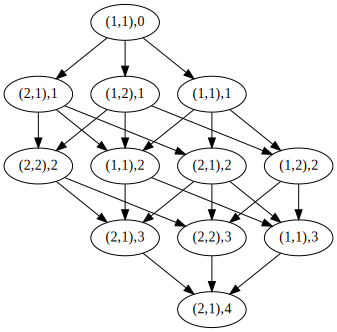

'Length of found solution: 2'
{'paths': [{'route': [{'x': 1, 'y': 1}, {'x': 2, 'y': 1}]}]}


<Figure size 432x288 with 0 Axes>

In [6]:
start: MarkedLocation = MarkedLocation(0, 1, 1)
goal: MarkedLocation = MarkedLocation(0, 2, 1)
problem: Problem = Problem([
    [1, 1, 1, 1],
    [1, 0, 0, 1],
    [1, 0, 0, 1],
    [1, 1, 1, 1]
], 4, 4, [start], [goal], 0, 1, 1)
solution = solve(problem)
pprint(solution.serialize())
# benchmark = MapfBenchmarker(
#     token="FXJ8wNVeWh4syRdh", problem_id=2,
#     algorithm="A*", version="test",
#     debug=True, solver=solve,
#     cores=8
# )
# benchmark.run()